In [ ]:
!pip install imageio

In [ ]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from matplotlib.colors import ListedColormap
import imageio
import os


In [ ]:
# Defining the forest class
class Forest:
    def __init__(self, n: int = 10, p: float = 0.1, diagonal: bool = False):
        self.n = n  # grid size
        self.p = p  # probability of open cell
        self.diagonal = diagonal  # diagonal connectivity

        self.grid = None
        self.random_grid = np.random.uniform(0, 1, (self.n, self.n))
        self.makegrid()

        self.groups = None
        self.visited = np.zeros((self.n, self.n))
        self.makegroups()

        self.fire_grid = np.zeros((self.n, self.n))
        self.burning_cells = []

    def makegrid(self):
        # 1: open, 0: closed
        self.grid = np.where(self.random_grid > self.p, 1, 0)
        self.visited = np.where(self.grid == 1, 1, 0)

    def printgrid(self):
        display_binary_matrix(self.grid)


    def bfs(self, i, j, group):
        queue = deque()

        queue.append((i,j))
        self.visited[i][j] = 1
        group += 1

        if not self.diagonal:
            directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        else:
            directions = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]


        while queue:
            cn = queue.popleft()

            for direction in directions:
                ni = cn[0] + direction[0]
                nj = cn[1] + direction[1]

                if ni < 0 or ni >= self.n or nj < 0 or nj >= self.n:
                    continue

                if self.visited[ni][nj] == 1:
                    continue

                if self.grid[ni][nj] == 0 :
                    queue.append((ni, nj))
                    self.visited[ni][nj] = 1
                    group += 1

        return group


    def makegroups(self):
        self.visited = np.zeros((self.n, self.n))
        groups = []

        # Find connected components using BFS
        for i in range(self.n):
            for j in range(self.n):
                if self.grid[i][j] == 0 and self.visited[i][j] == 0:
                    group = 0
                    group = self.bfs(i, j, group)
                    groups.append(group)

        self.groups = groups

    def _debug_printgroups(self):
        for i, group in enumerate(self.groups):
            print(f"Group {i}: {len(group)}")
            print(f"Group {i}: {group}")


    def printgroups(self):
        cmap = get_cmap(len(self.groups), name='hsv')
        matrix = np.zeros((self.n, self.n))
        for i, group in enumerate(self.groups):
            for cell in group:
                matrix[cell[0]][cell[1]] = i + 1
        display_coloured_matrix(matrix)

    def ignite(self, start_cells=[(0, 0)]):
        """Function to start the fire in the grid"""
        for i, j in start_cells:
            if self.grid[i][j] == 0:
                # burn this cell
                self.fire_grid[i][j] = 1
                self.burning_cells.append((i, j))

    def step_fire(self):
      new_burning = []
      directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
      if self.diagonal:
          directions += [(1, 1), (-1, -1), (-1, 1), (1, -1)]

      for i, j in self.burning_cells:
          for di, dj in directions:
              ni, nj = i + di, j + dj
              if 0 <= ni < self.n and 0 <= nj < self.n:
                  # if the site is open and the site is not already burnt
                  if self.grid[ni][nj] == 0 and self.fire_grid[ni][nj] == 0:
                      self.fire_grid[ni][nj] = 1
                      new_burning.append((ni, nj))

      self.burning_cells = new_burning
      return len(new_burning) > 0

    def show_fire(self, save_path = None):
      vis = np.zeros((self.n, self.n))
      for i in range(self.n):
          for j in range(self.n):
              if self.grid[i][j] == 1:
                  vis[i][j] = -1  # Closed site, no tree (will be ignored visually)
              elif self.fire_grid[i][j] == 0:
                  vis[i][j] = 0  # Unburned tree
              elif self.fire_grid[i][j] == 1:
                  vis[i][j] = 1  # Burning tree

      # mask(do not color) the closed (non-tree) sites
      masked_vis = np.ma.masked_where(vis == -1, vis)
      # color 0s in green and 1s in orange
      cmap = ListedColormap(['green', '#eb6734'])

      # clear the output and plot the new grid
      clear_output(wait=True)
      plt.figure(figsize=(5, 5))
      plt.imshow(masked_vis, cmap=cmap, interpolation='nearest')
      plt.title(f"p = {self.p}")
      plt.xticks([])
      plt.yticks([])
      if save_path:
        plt.savefig(save_path)
      plt.close()

In [ ]:
# Forest with wind influence blowing towards east
class ForestWithWindInfluence(Forest):
    def __init__(self, n: int = 10, p: float = 0.1, diagonal: bool = False, wind_influence: dict = {(0,1) : 1.0,
                               (0,-1) : 0.001,
                               (1, 0) : 0.5,
                               (-1,0): 0.5}):

        self.wind_influence = wind_influence

        self.diagonal = diagonal

        if self.diagonal:
            self.wind_influence.update({(1, 1) : 0.7,
                                        (1, -1) : 0.001,
                                        (-1, 1) : 0.7,
                                        (-1, -1) : 0.001})

        super().__init__(n, p, diagonal)


    def bfs(self, i, j, group):
        queue = deque()

        queue.append((i,j))
        self.visited[i][j] = 1
        group += 1

        if not self.diagonal:
            directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        else:
            directions = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]


        while queue:
            cn = queue.popleft()

            for direction in directions:
                ni = cn[0] + direction[0]
                nj = cn[1] + direction[1]

                if ni < 0 or ni >= self.n or nj < 0 or nj >= self.n:
                    continue

                if self.visited[ni][nj] == 1:
                    continue

                if self.grid[ni][nj] == 0 :
                    if np.random.uniform(0, 1) < self.wind_influence[(direction[0], direction[1])]:
                        queue.append((ni, nj))
                        self.visited[ni][nj] = 1
                        group += 1

        return group

        def step_fire(self):
          new_burning = []
          directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
          if self.diagonal:
            directions += [(1, 1), (-1, -1), (-1, 1), (1, -1)]

          for i, j in self.burning_cells:
            for di, dj in directions:
              ni, nj = i + di, j + dj
              if 0 <= ni < self.n and 0 <= nj < self.n:
                # if the site is open and the site is not already burnt
                if self.grid[ni][nj] == 0 and self.fire_grid[ni][nj] == 0:
                  if np.random.uniform(0, 1) < self.wind_influence[(di, dj)]:
                    self.fire_grid[ni][nj] = 1
                    new_burning.append((ni, nj))

          self.burning_cells = new_burning
          return len(new_burning) > 0

In [ ]:
#Visualization code
def display_binary_matrix(matrix):
    matrix = np.array(matrix)

    fig, ax = plt.subplots()
    ax.imshow(matrix, cmap='Greys', interpolation='none')

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)

    # Turn off axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

# Taken from https://stackoverflow.com/a/25628397
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

def display_coloured_matrix(matrix, cmap=None):
    matrix = np.array(matrix)

    fig, ax = plt.subplots()
    if cmap is None:
        cmap = get_cmap(matrix.shape[0]*matrix.shape[1])
    ax.imshow(matrix, cmap=cmap, interpolation='none')

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)

    # Turn off axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [ ]:
def simulate_fire(p, file_name=None):
    forest = Forest(n=20, p=p, diagonal=True)
    forest.ignite([(0,0)])

    frames = []

    os.makedirs('frames', exist_ok=True)

    step = 0
    if not file_name:
      forest.show_fire(save_path=f'frames/frame_{step:03d}.png')
    else:
      forest.show_fire(save_path=f'frames/{file_name}_frame_{step:03d}.png')

    step += 1
    # if there are more burning cells
    while forest.step_fire():
        if not file_name:
          forest.show_fire(save_path=f'frames/frame_{step:03d}.png')
        else:
          forest.show_fire(save_path=f'frames/{file_name}_frame_{step:03d}.png')
        step += 1

    # After simulation ends, make gif
    images = []
    for i in range(step):
        if not file_name:
          filename = f'frames/frame_{i:03d}.png'
        else:
          filename = f'frames/{file_name}_frame_{i:03d}.png'
        images.append(imageio.imread(filename))
    if not file_name:
      imageio.mimsave('forest_fire.gif', images, duration=0.5)
    else:
      imageio.mimsave(f'{file_name}.gif', images, duration=0.5)

In [ ]:
simulate_fire(0.8)

<ipython-input-7-9adb2faf64ec>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


## Modeling Moisture into p

### Linear Modeling

For a moisture value M, p_new = p * (1 - M)

100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
<ipython-input-9-690b5e8c6193>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


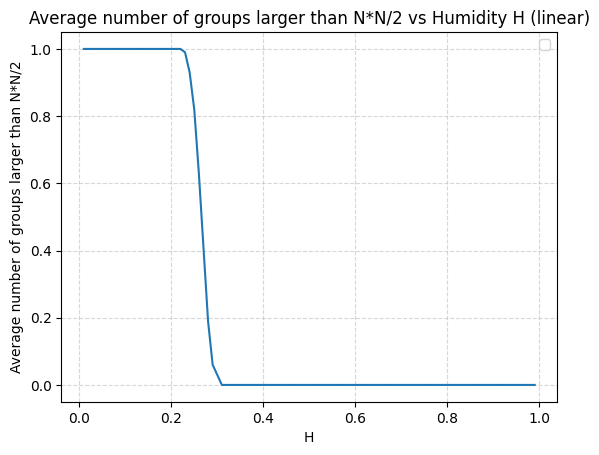

In [ ]:
from tqdm import tqdm
def linear_moisture_model():
  grid_size = 50
  p = 0.7
  iterations = 100
  moisture_range = [0.01*i for i in range(1,100)]
  history = np.zeros((len(moisture_range)))

  for M in tqdm(moisture_range):
    p_new = p * (1-M)
    for i in range(iterations):
        forest = Forest(grid_size, p_new, True)
        # group_size: number of sites in the group
        history[moisture_range.index(M)] += np.sum([1 for group_size in forest.groups if group_size >= grid_size*grid_size/2])

  history /= iterations
  fig, ax = plt.subplots()
  ax.plot(moisture_range, history)
  ax.set_xlabel("H")
  ax.set_ylabel("Average number of groups larger than N*N/2")
  ax.set_title("Average number of groups larger than N*N/2 vs Humidity H (linear)")
  ax.legend()
  ax.grid(linestyle='--', alpha=0.5)
  plt.savefig("count_largest_groups_moisture.png", dpi=300)
  plt.show()

linear_moisture_model()

In [ ]:
# Simulating forest fires with moisture levels
def simulate_fire_with_moisture(p, file_name=None):
    forest = Forest(n=20, p=p, diagonal=True)
    forest.ignite([(0,0)])

    frames = []

    os.makedirs('frames', exist_ok=True)

    step = 0
    if not file_name:
      forest.show_fire(save_path=f'frames/frame_{step:03d}.png')
    else:
      forest.show_fire(save_path=f'frames/{file_name}_frame_{step:03d}.png')

    step += 1
    # if there are more burning cells
    while forest.step_fire():
        if not file_name:
          forest.show_fire(save_path=f'frames/frame_{step:03d}.png')
        else:
          forest.show_fire(save_path=f'frames/{file_name}_frame_{step:03d}.png')
        step += 1

    # After simulation ends, make gif
    images = []
    for i in range(step):
        if not file_name:
          filename = f'frames/frame_{i:03d}.png'
        else:
          filename = f'frames/{file_name}_frame_{i:03d}.png'
        images.append(imageio.imread(filename))
    if not file_name:
      imageio.mimsave('forest_fire.gif', images, duration=0.5)
    else:
      imageio.mimsave(f'{file_name}.gif', images, duration=0.5)

### Non-Linear Model

p_new = p * e ^ (-kM)

100%|██████████| 99/99 [01:19<00:00,  1.25it/s]
<ipython-input-11-fb14d6aaf516>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


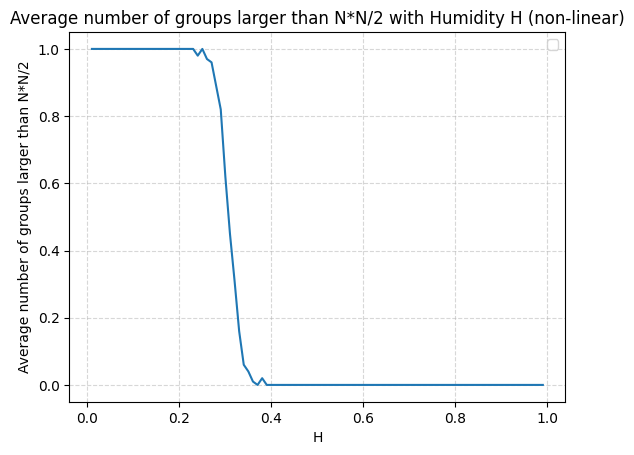

In [ ]:
from tqdm import tqdm
import math
def nonlinear_moisture_model():
  N = 50
  p = 0.7
  k = 1
  iterations = 100
  M_range = [0.01*i for i in range(1,100)]
  history = np.zeros((len(M_range)))
  for M in tqdm(M_range):
    p_new = p * (math.e ** (-k * M))
    # print(f"{p_new}")
    for i in range(iterations):
        forest = Forest(N, p_new, True)
        history[M_range.index(M)] += np.sum([1 for group in forest.groups if group >= N*N/2])
  history /= iterations
  fig, ax = plt.subplots()
  ax.plot(M_range, history)
  ax.set_xlabel("H")
  ax.set_ylabel("Average number of groups larger than N*N/2")
  ax.set_title("Average number of groups larger than N*N/2 vs Humidity H (non-linear)")
  ax.legend()
  ax.grid(linestyle='--', alpha=0.5)
  plt.savefig("count_largest_groups_moisture_nonlinear.png", dpi=300)
  plt.show()

nonlinear_moisture_model()

# Simulate fire with wind influence

In [ ]:
# Demo Fire with the influence of wind (Blowing East)
def simulate_fire_with_wind(p):
    forest = ForestWithWindInfluence(n=80, p=p, diagonal=True)
    forest.ignite([(40,40)])

    frames = []

    os.makedirs('frames', exist_ok=True)

    step = 0
    forest.show_fire(save_path=f'frames/frame_{step:03d}.png')
    step += 1
    while forest.step_fire():
        forest.show_fire(save_path=f'frames/frame_{step:03d}.png')
        step += 1

    # After simulation ends, make gif
    images = []
    for i in range(step):
        filename = f'frames/frame_{i:03d}.png'
        images.append(imageio.imread(filename))
    imageio.mimsave('forest_fire.gif', images, duration=0.5)

In [ ]:
simulate_fire_with_wind(0.5)

<ipython-input-65-c94bb87b44f6>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


100%|██████████| 4/4 [05:26<00:00, 81.62s/it] 


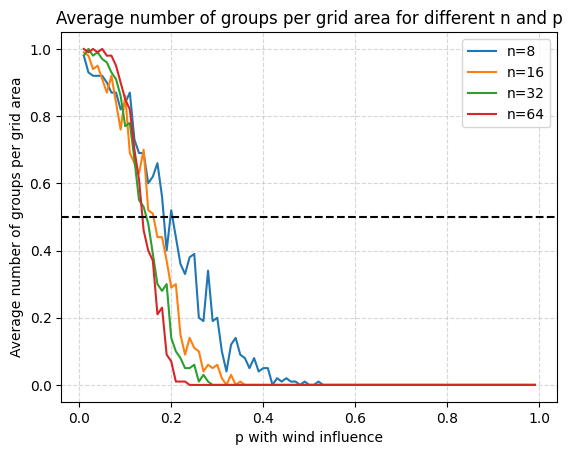

In [ ]:
from tqdm import tqdm
def linear_wind_model():
    n_range = [2**i for i in range(3, 7)]
    p_range = [0.01*i for i in range(1, 100)]
    iterations = 100
    n_critical = 0.5

    history = np.zeros((len(n_range), len(p_range)))

    for n in tqdm(n_range):
        # print(f"n: {n}")
        for p in p_range:
            for i in range(iterations):
                forest = ForestWithWindInfluence(n, p, True)
                history[n_range.index(n)][p_range.index(p)] += np.sum([1 for group in forest.groups if group >= n*n/2])

    history /= iterations

    fig, ax = plt.subplots()
    for i, n in enumerate(n_range):
        ax.plot(p_range[::-1], history[i], label=f"n={n}")
    ax.set_xlabel("p with wind influence")
    ax.set_ylabel("Average number of groups per grid area")
    ax.set_title("Average number of groups per grid area for different n and p")
    ax.legend()
    ax.grid(linestyle='--', alpha=0.5)
    ax.axhline(n_critical, linestyle='--', color='k')
    plt.savefig("count_largest_groups_diagonal.png", dpi=300)
    plt.show()

linear_wind_model()

99it [19:10, 11.62s/it]
<ipython-input-41-145e97e9994b>:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


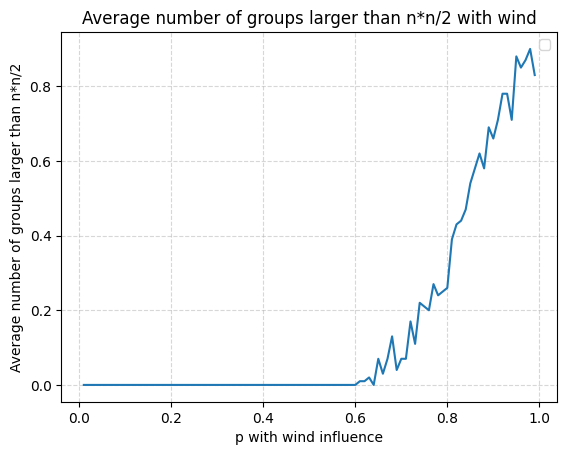

In [ ]:
from tqdm import tqdm
def scale_wind_influence(base_wind_influence, scale_factor):
    return {direction: prob * scale_factor for direction, prob in base_wind_influence.items()}

def linear_wind_model():
    grid_size = 100
    p = 0.9
    iterations = 100

    # Base dictionary
    base_wind_influence = {
        (0, 1): 1.0,    # East
        (0, -1): 0.001, # West
        (1, 0): 0.5,    # South
        (-1, 0): 0.5    # North
    }

    # Example: Create different scaled versions
    scales = [0.01*i for i in range(1,100)]  # Different wind strengths
    wind_influences = [scale_wind_influence(base_wind_influence, s) for s in scales]
    history = np.zeros(len(scales))

    # print(wind_influences)

    for idx, w in tqdm(enumerate(wind_influences)):
      for i in range(iterations):
          # print(w)
          forest = ForestWithWindInfluence(grid_size, p, True, w)
          # group_size: number of sites in the group
          history[wind_influences.index(w)] += np.sum([1 for group_size in forest.groups if group_size >= grid_size*grid_size/2])

    history /= iterations
    fig, ax = plt.subplots()
    # print(len(scales), history.shape)
    ax.plot(scales, history)
    # ax.plot(history)
    ax.set_xlabel("p with wind influence")
    ax.set_ylabel("Average number of groups larger than n*n/2")
    ax.set_title("Average number of groups larger than n*n/2 with wind")
    ax.legend()
    ax.grid(linestyle='--', alpha=0.5)
    plt.savefig("count_largest_groups_wind.png", dpi=300)
    plt.show()

linear_wind_model()

## Both moisture and wind

100%|██████████| 99/99 [02:14<00:00,  1.36s/it]
<ipython-input-8-68c9d26bd002>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


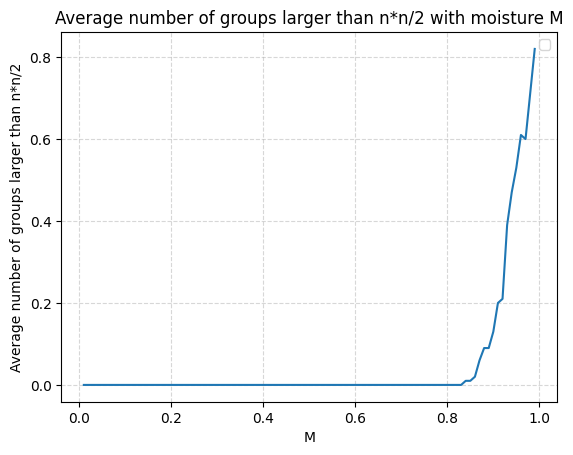

In [ ]:
from tqdm import tqdm
def linear_moisture_wind_model():
  grid_size = 50
  p = 0.9
  iterations = 100
  moisture_range = [0.01*i for i in range(1,100)]
  history = np.zeros((len(moisture_range)))

  for M in tqdm(moisture_range):
    p_new = p * (1-M)
    for i in range(iterations):
        forest = ForestWithWindInfluence(grid_size, p_new, True)
        # group_size: number of sites in the group
        history[moisture_range.index(M)] += np.sum([1 for group_size in forest.groups if group_size >= grid_size*grid_size/2])

  history /= iterations
  fig, ax = plt.subplots()
  ax.plot(moisture_range[::-1], history)
  ax.set_xlabel("M")
  ax.set_ylabel("Average number of groups larger than n*n/2")
  ax.set_title("Average number of groups larger than n*n/2 with moisture M")
  ax.legend()
  ax.grid(linestyle='--', alpha=0.5)
  plt.savefig("count_largest_groups_moisture.png", dpi=300)
  plt.show()

linear_moisture_wind_model()

100%|██████████| 99/99 [02:47<00:00,  1.69s/it]
<ipython-input-9-86b7a5e84084>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


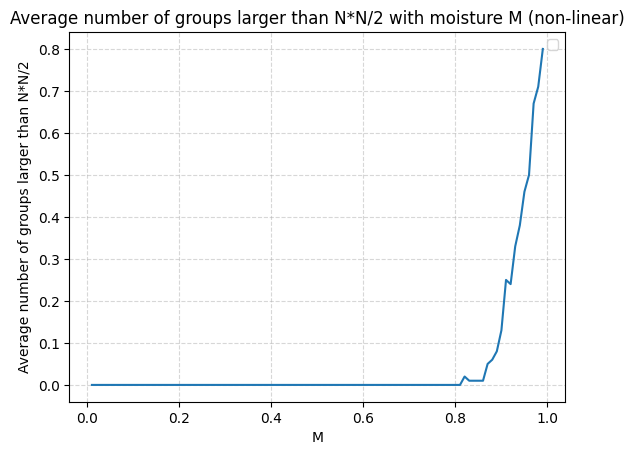

In [ ]:
from tqdm import tqdm
import math
def nonlinear_moisture_wind_model():
  N = 50
  p = 0.9
  k = 1
  iterations = 100
  M_range = [0.01*i for i in range(1,100)]
  history = np.zeros((len(M_range)))
  for M in tqdm(M_range):
    p_new = p * (math.e ** (-k * M))
    # print(f"{p_new}")
    for i in range(iterations):
        forest = ForestWithWindInfluence(N, p_new, True)
        history[M_range.index(M)] += np.sum([1 for group in forest.groups if group >= N*N/2])
  history /= iterations
  fig, ax = plt.subplots()
  ax.plot(M_range[::-1], history)
  ax.set_xlabel("M")
  ax.set_ylabel("Average number of groups larger than N*N/2")
  ax.set_title("Average number of groups larger than N*N/2 with moisture M (non-linear)")
  ax.legend()
  ax.grid(linestyle='--', alpha=0.5)
  plt.savefig("count_largest_groups_moisture_nonlinear.png", dpi=300)
  plt.show()

nonlinear_moisture_wind_model()